# DATA 606 - Capstone Project - Zach Vance

In this file I take the cleaned data and query it to create visualizations to help guide us to the answers we are looking for from EDA analysis.

In [1]:
# imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, DoubleType, IntegerType, DateType
from pandas_profiling import ProfileReport
import pandas as pd
import pyspark.sql.functions as f

In [2]:
# Create the spark session and context.
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
# Create the schema with the column names, type, and nullable as true or false
schema = StructType([ \
    StructField("index", IntegerType(), True), \
    StructField("MLSNumber", StringType(), True), \
    StructField("DOM", IntegerType(), True), \
    StructField("CDOM", IntegerType(), True), \
    StructField("ListDate", StringType(), True), \
    StructField("AgreementOfSaleSignedLeaseDate", StringType(), True), \
    StructField("OffMarketDate", StringType(), True), \
    StructField("SettledDate", StringType(), True), \
    StructField("OriginalPrice", StringType(), True), \
    StructField("ListPrice", StringType(), True), \
    StructField("SoldPrice", StringType(), True), \
    StructField("StreetNumber", IntegerType(), True), \
    StructField("StreetDirection", StringType(), True), \
    StructField("StreetName", StringType(), True), \
    StructField("UnitNumber", IntegerType(), False), \
    StructField("City", StringType(), True), \
    StructField("ZipCode", IntegerType(), True), \
    StructField("County", StringType(), True), \
    StructField("Subdivision", StringType(), True), \
    StructField("ListAgentName", StringType(), True), \
    StructField("ListAgentCode", IntegerType(), True), \
    StructField("ListOfficeName", StringType(), True), \
    StructField("ListOfficeCode", StringType(), True), \
    StructField("SellingAgent", StringType(), True), \
    StructField("SellingAgentCode", IntegerType(), True), \
    StructField("SellingOfficeName", StringType(), True), \
    StructField("SellingOfficeCode", StringType(), True), \
    StructField("SellerConcessionsAmount", StringType(), True), \
    StructField("FinalFinancing", StringType(), True), \
    StructField("FinalShortSale", StringType(), True), \
    StructField("FinalThirdPartyApproval", StringType(), True), \
    StructField("FinalBankOwned", StringType(), True), \
    StructField("TaxAnnualTotal", IntegerType(), True), \
    StructField("TaxYear", IntegerType(), True), \
    StructField("AcresTotal", DoubleType(), True), \
    StructField("LandUseCode", IntegerType(), True), \
    StructField("Ownership", StringType(), True), \
    StructField("SeniorCommunity", StringType(), False), \
    StructField("CondoCoopAssoc", StringType(), True), \
    StructField("HOA", StringType(), True), \
    StructField("OneTimeAssociationFee", StringType(), True), \
    StructField("AssociationFee", IntegerType(), True), \
    StructField("AssociationFeeFrequency", StringType(), True), \
    StructField("Age", IntegerType(), True), \
    StructField("InteriorSqFt", IntegerType(), True), \
    StructField("PropertyCondition", StringType(), True), \
    StructField("Bedrooms", IntegerType(), True), \
    StructField("BathsFull", IntegerType(), True), \
    StructField("BathsHalf", IntegerType(), True), \
    StructField("Design", StringType(), True), \
    StructField("Style", StringType(), True), \
    StructField("NumberofStories", StringType(), True), \
    StructField("FloorNumber", IntegerType(), True), \
    StructField("Basement", StringType(), True), \
    StructField("GarageSpaces", IntegerType(), True), \
    StructField("Fireplace", StringType(), True), \
    StructField("Laundry", StringType(), True), \
    StructField("OtherRooms", StringType(), True), \
    StructField("RoomCount", IntegerType(), True), \
    StructField("CentralAir", StringType(), True), \
    StructField("Waterfront", StringType(), True), \
    StructField("NewConstruction", StringType(), True), \
    StructField("ModelName", StringType(), True), \
    StructField("BuyerBrokerCompensation", DoubleType(), True), \
    StructField("SubAgentCompensation", DoubleType(), True), \
    StructField("TransactionBrokerCompensation", DoubleType(), True), \
    StructField("OriginatingMLS", StringType(), True), \
    StructField("AboveGradeSqFt", IntegerType(), True), \
    StructField("BelowGradeSqFt", IntegerType(), True), \
    StructField("HomeBuilt", StringType(), True), \
    StructField("BasementFootprintPct", DoubleType(), True), \
    StructField("BasementFinishedPct", DoubleType(), True)
  ])

In [4]:
# Read in the appended data
df = spark.read.csv("../CleanedData/cleaned_data.csv", sep=",", schema=schema, header=True)

In [5]:
# Convert the columns that came in as strings using dollars to integers
df = df.withColumn('OriginalPrice', f.regexp_replace('OriginalPrice', '[$,]', '').cast('integer'))
df = df.withColumn('ListPrice', f.regexp_replace('ListPrice', '[$,]', '').cast('integer'))
df = df.withColumn('SoldPrice', f.regexp_replace('SoldPrice', '[$,]', '').cast('integer'))
df = df.withColumn('SellerConcessionsAmount', f.regexp_replace('SellerConcessionsAmount', '[$,]', '').cast('integer'))


In [6]:
# Verify the count
df.count()

90758

In [15]:
# Cache the dataframe
dfCache = df.cache()

In [9]:
# Run the pandas profile report for initial exploration
profile = ProfileReport(dfCache.toPandas(), title="Pandas Profiling Report", minimal=True)
profile

In [10]:
# Write the output to the reports folder.
profile.to_file(output_file="../Reports/cleaned_data_pandas_profile.html")

In [30]:
# Verify the unique 4 counties exist - Anne Arundel, Baltimore, Harford, Howard
# Just a test of the agg function
dfCache.agg(f.countDistinct('County')).show()

+-------------+
|count(County)|
+-------------+
|            4|
+-------------+



In [21]:
# Use SQL to query for the average price per county, per date.  Grouped by each Month's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT MONTH(to_date(SettledDate, 'M/d/y')) AS Date, County, avg(SoldPrice) as Price
FROM housing_data
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|       County|             Price|
+----+-------------+------------------+
|  12|    HARFORDMD| 369317.3697813121|
|  12|     HOWARDMD| 611608.2491694352|
|  12|  BALTIMOREMD|370341.63171355496|
|  12|ANNEARUNDELMD|  522959.279725917|
|  11|ANNEARUNDELMD|511572.12824675324|
|  11|    HARFORDMD|369408.62003968254|
|  11|  BALTIMOREMD|372355.39094339625|
|  11|     HOWARDMD| 605927.4270833334|
|  10|    HARFORDMD| 369276.2063789869|
|  10|     HOWARDMD|  607932.259222333|
|  10|ANNEARUNDELMD|497354.59444048465|
|  10|  BALTIMOREMD|373794.95621959696|
|   9|     HOWARDMD| 619170.7897111913|
|   9|ANNEARUNDELMD|  507577.040954416|
|   9|  BALTIMOREMD| 370686.8321060383|
|   9|    HARFORDMD| 378948.9650485437|
|   8|  BALTIMOREMD| 381113.1599388379|
|   8|     HOWARDMD| 625300.9076127125|
|   8|ANNEARUNDELMD| 512796.6229613048|
|   8|    HARFORDMD| 388684.0317337461|
+----+-------------+------------------+
only showing top 20 rows



In [22]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


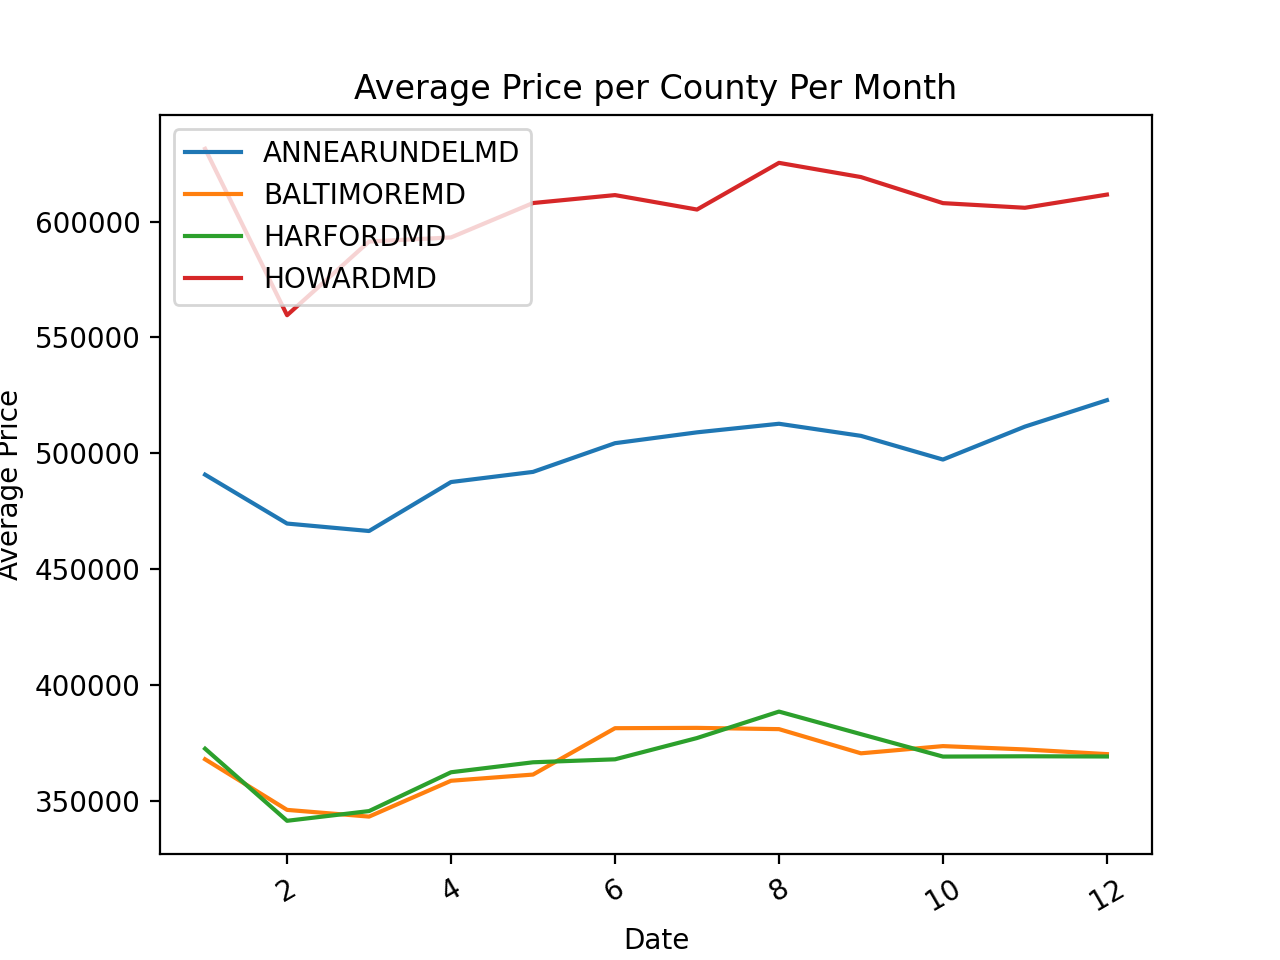

<function matplotlib.pyplot.show(block=None)>

In [25]:
%matplotlib notebook

# Plot the price by date for each County on the same chart for comparison.
by_label = pdf.groupby('County')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per County Per Month")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.show


From the above chart we can easily see that Howard county is the most expensive, followed by Anne Arundel, then by both Harford and Baltimore being similar price levels.  Interestingly, the price movements up and down seem to follow the same trend over the course of the year.  As the proce in Howard goes up towards the summer months, so does the price in Anne Arundel and the other counties, at about the same rate as well.

In [26]:
# Use SQL to query for the average price per county, per date.  Grouped by each year's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, County, avg(SoldPrice) as Price
FROM housing_data
GROUP BY Date, County
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|       County|             Price|
+----+-------------+------------------+
|  22|    HARFORDMD| 434501.1098265896|
|  22|  BALTIMOREMD|446397.42052313883|
|  22|     HOWARDMD| 688254.9925373135|
|  22|ANNEARUNDELMD| 545064.7616580311|
|  21|     HOWARDMD| 698511.9186172128|
|  21|    HARFORDMD|432373.33827893174|
|  21|  BALTIMOREMD|425179.93201634876|
|  21|ANNEARUNDELMD| 576423.7605748373|
|  20|    HARFORDMD| 383072.2459379616|
|  20|  BALTIMOREMD|382289.84152208775|
|  20|     HOWARDMD| 616681.3457798522|
|  20|ANNEARUNDELMD| 521416.9277604314|
|  19|     HOWARDMD| 575447.4572008114|
|  19|  BALTIMOREMD| 348146.2355527638|
|  19|    HARFORDMD| 351071.7452563585|
|  19|ANNEARUNDELMD| 471692.1456857695|
|  18|     HOWARDMD|  570454.003773585|
|  18|ANNEARUNDELMD|462082.06363949087|
|  18|    HARFORDMD|333621.37216404884|
|  18|  BALTIMOREMD|  339546.158598207|
+----+-------------+------------------+
only showing top 20 rows



In [27]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


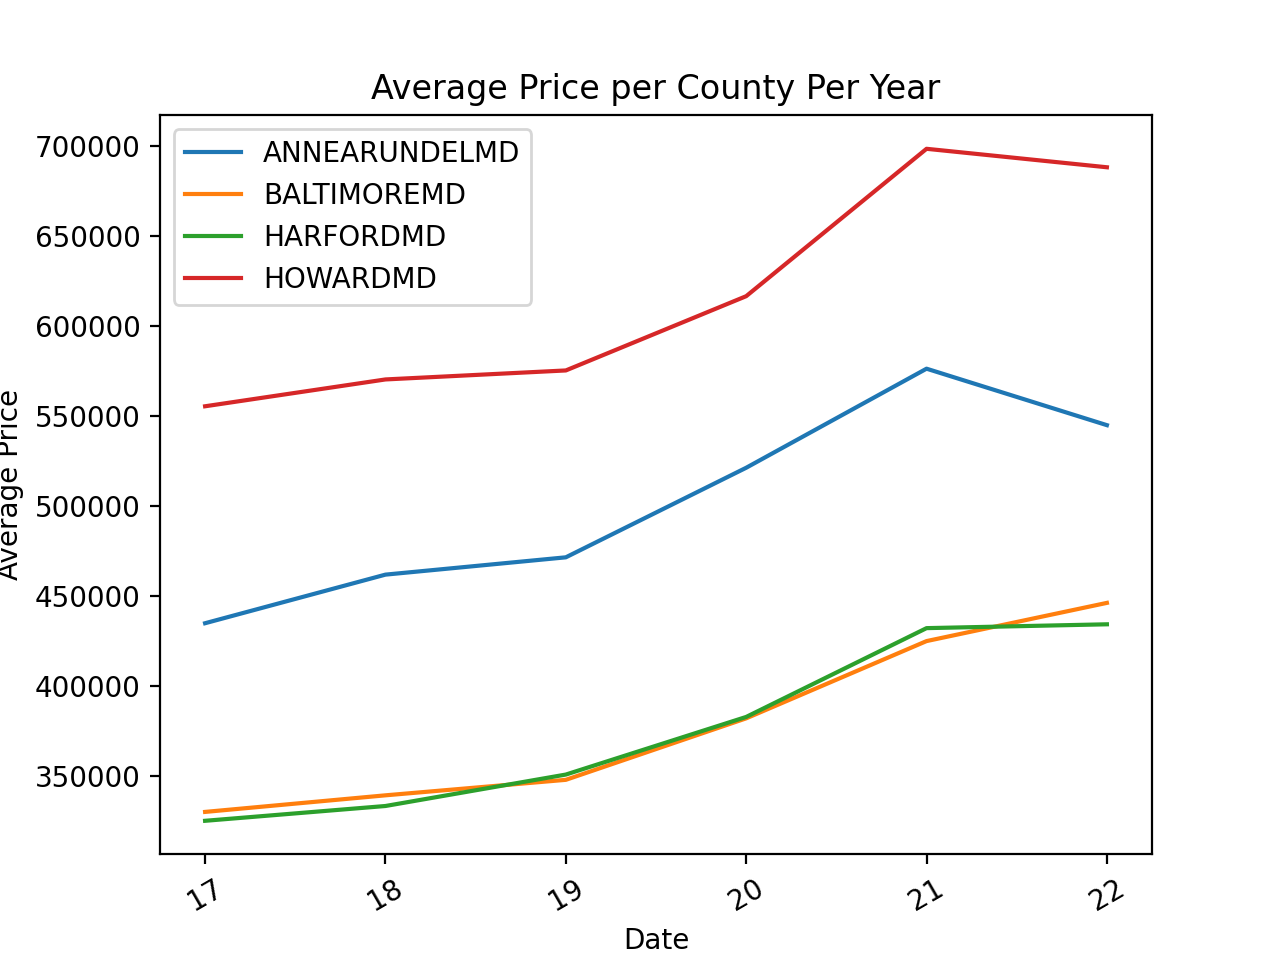

<function matplotlib.pyplot.show(block=None)>

In [28]:
%matplotlib notebook

# Plot the price by date for each County on the same chart for comparison.
by_label = pdf.groupby('County')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per County Per Year")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.show



From the above chart we can easily see the upward trend in the cost of house prices over the years.  We see again the same ordering of price levels of the 4 counties and increases at similar rates.  Home prices look to have peaked in 2021 and have so far leveled off or decreased slightly so far into 2022.

In [50]:
# Use SQL to query for the average price per county, per date.  Grouped by each year's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, City, avg(SoldPrice) as Price
FROM housing_data
WHERE County = 'HARFORDMD'
GROUP BY Date, City
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+--------------+------------------+
|Date|          City|             Price|
+----+--------------+------------------+
|  22|Havre De Grace|        347811.125|
|  22|   Forest Hill| 572658.3333333334|
|  22|      Fallston|          512500.0|
|  22|   Churchville|          460400.0|
|  22|         Joppa|        394943.875|
|  22|    Darlington| 343166.6666666667|
|  22|       Bel Air| 530004.6511627907|
|  22|    Pylesville| 533966.6666666666|
|  22|       Baldwin|          622500.0|
|  22| Jarrettsville| 435190.3333333333|
|  22|      Aberdeen| 332914.2380952381|
|  22|      Edgewood| 269874.6923076923|
|  22|       Belcamp|          277000.0|
|  22|        Street| 459309.0909090909|
|  22|      Abingdon|409058.82352941175|
|  21|        Street|     546274.421875|
|  21|       Belcamp| 304412.2727272727|
|  21|    Pylesville|496386.95652173914|
|  21|    Darlington|          367613.5|
|  21|Havre De Grace| 400942.9246861925|
+----+--------------+------------------+
only showing top

In [51]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


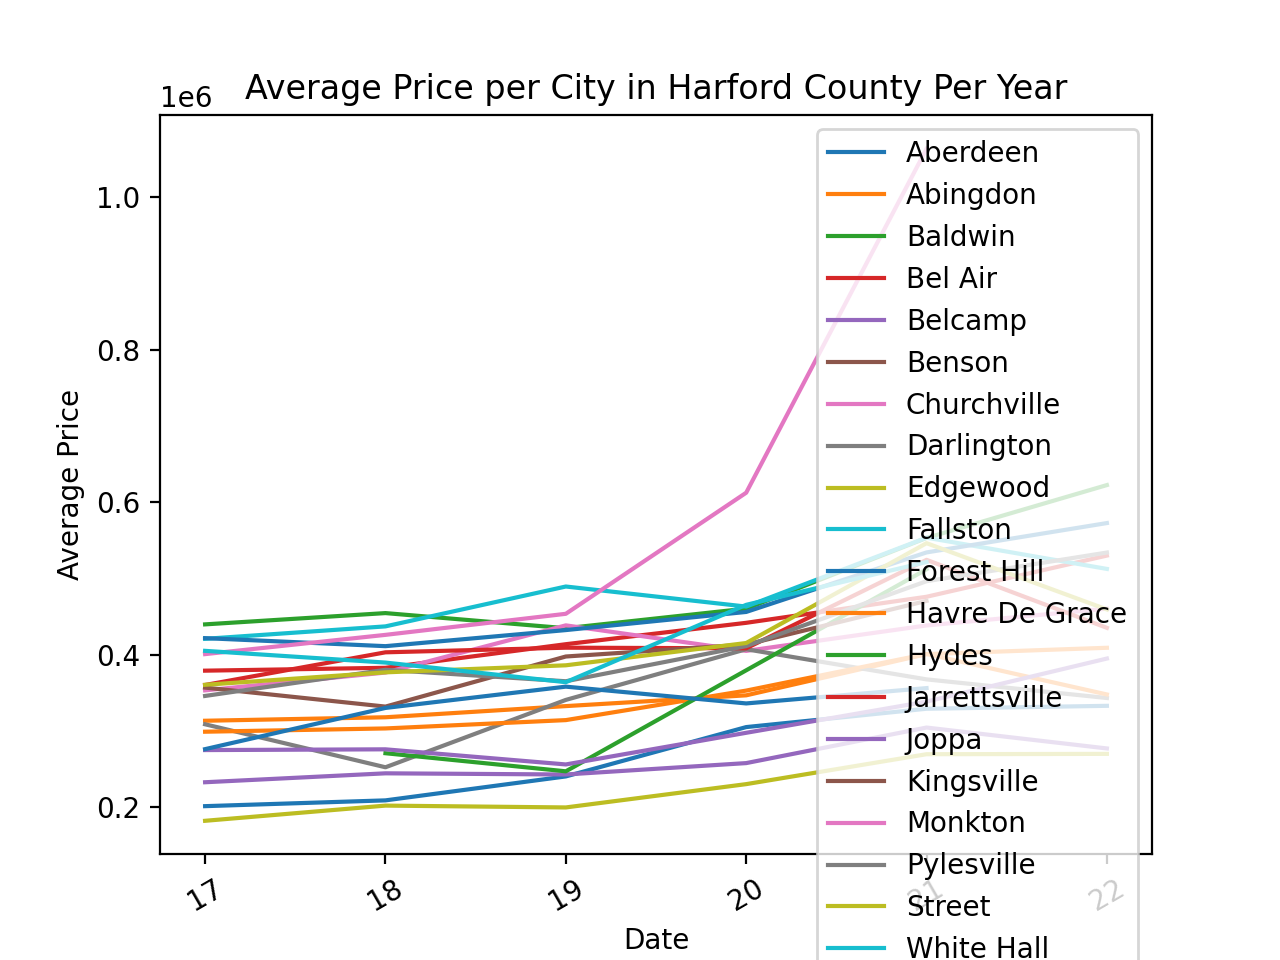

<function matplotlib.pyplot.show(block=None)>

In [52]:
%matplotlib notebook

# Plot the price by date for each City in Harford County on the same chart for comparison.
by_label = pdf.groupby('City')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per City in Harford County Per Year")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.show




Breaking the data down even further, we can query by city inside of each County, it is easier to graph on a chart like this if we look more specifically at certain cities we are interested in as there are just too many to put on one chart and for it to be legible.  Another concern with this is that when the data is at a level this low and we are usign the average, an outlier has more potential to throw off the results.  For instance, prices in Churchville look to have skyrockets going into 2021, that could be due to a couple outliers or there could be another reason - and that is something to look into further.

In [53]:
# Use SQL to query for the average price per county, per date.  Grouped by each year's average price.

dfCache = dfCache.filter(dfCache.SoldPrice.isNotNull())
dfCache = dfCache.filter(dfCache.SettledDate.isNotNull())
dfCache.createOrReplaceTempView('housing_data')

query = """
SELECT YEAR(to_date(SettledDate, 'M/d/y')) AS Date, City, avg(SoldPrice) as Price
FROM housing_data
WHERE County = 'ANNEARUNDELMD' AND Waterfront = 'Yes'
GROUP BY Date, City
ORDER BY Date desc
"""
output = spark.sql(query)
output.show()

# Data is shown to ensure it looks correct.

+----+-------------+------------------+
|Date|         City|             Price|
+----+-------------+------------------+
|  22|   Shady Side|          875000.0|
|  22|    Annapolis|         1277500.0|
|  22|     Pasadena|         1119470.0|
|  22|    Edgewater|1276666.6666666667|
|  22|       Arnold|         1502500.0|
|  22|  Glen Burnie| 393333.3333333333|
|  22|    Churchton|         1550000.0|
|  22|         Mayo|         1100000.0|
|  22|Davidsonville|         1375000.0|
|  21|       Arnold|      1445000.3125|
|  21| Severna Park|1646705.8823529412|
|  21|    Churchton| 689883.3333333334|
|  21|        Deale|          751000.0|
|  21|   West River|         1095000.0|
|  21|  Crownsville|1549026.3157894737|
|  21|   Friendship|         3330000.0|
|  21|      Hanover|          325000.0|
|  21|   Shady Side| 739474.8947368421|
|  21| Stoney Beach|          485000.0|
|  21|   Galesville|         895397.75|
+----+-------------+------------------+
only showing top 20 rows



In [54]:
import matplotlib.pyplot as plt

# Prepare to plot the chart by date of the data.
pdf = (
    output
    .orderBy("Date")
    .toPandas()
)

<IPython.core.display.Javascript object>


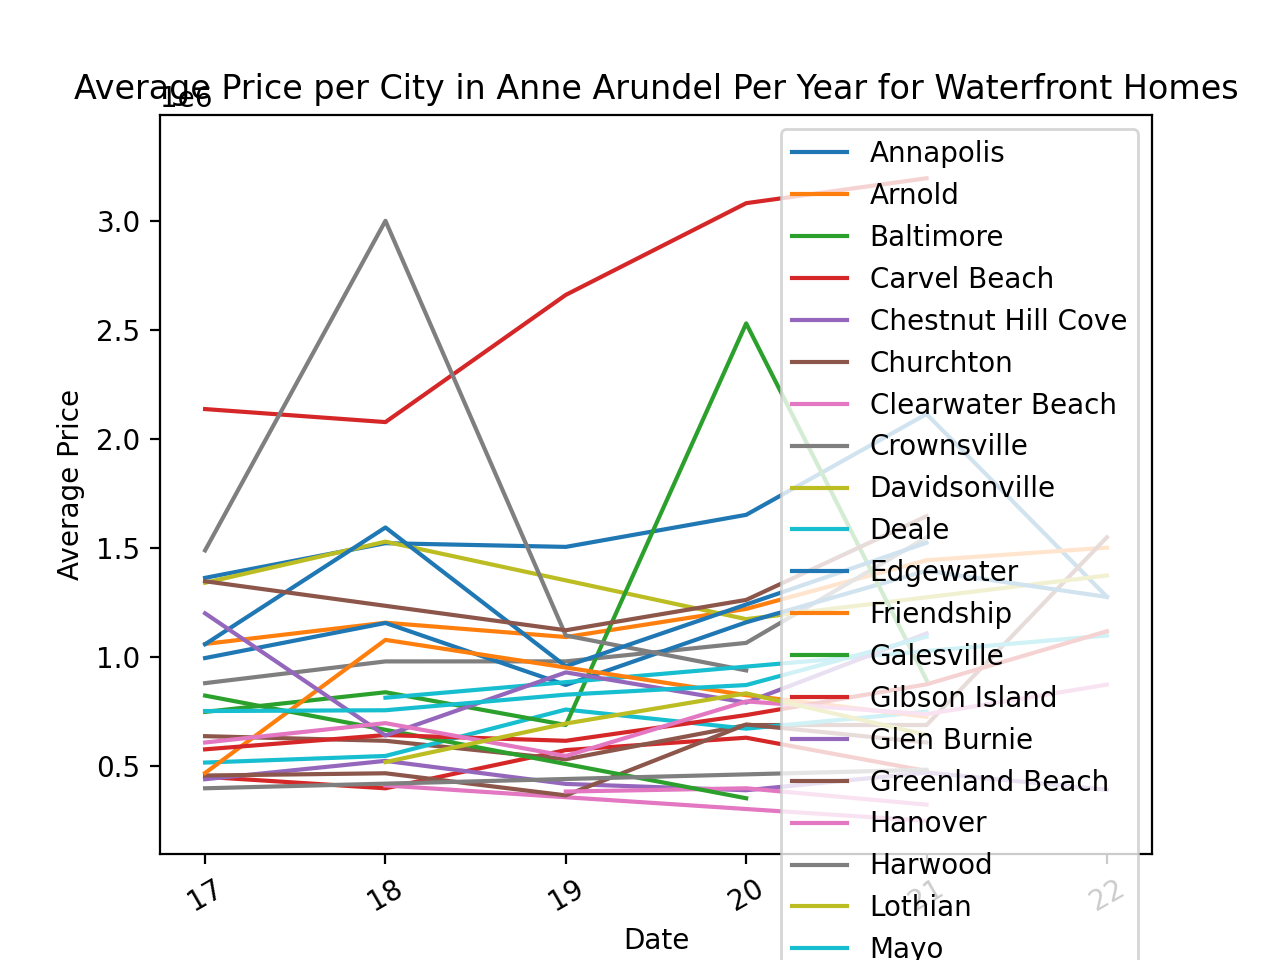

<function matplotlib.pyplot.show(block=None)>

In [55]:
%matplotlib notebook

# Plot the price by date for each City in Anne Arundel County on the same chart for comparison.
by_label = pdf.groupby('City')
by_label

for name, group in by_label:
    plt.plot(group['Date'], group['Price'], label=name)

plt.title("Average Price per City in Anne Arundel Per Year for Waterfront Homes")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.legend()
plt.show





With being interested in waterfront property myself in Anne Arundel county it is helpful for me to see where the most affordable waterfront property is, and how prices for it have trended over the last 5 years.  Hanover looks to be the most affordable, and to have stayed relatively flat over the years, which may be good for a lower price purchasing the land, but also hinders the outlook as an investment and looking to gain the most possible from appreciation of the property.